In [1]:
from collections import defaultdict
import os
import sys
sys.path.append('..')

import pandas as pd
from tqdm import tqdm
import torch
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.nn.util import move_to_device

from adat.utils import load_weights, calculate_wer
from adat.masker import SimpleMasker, MASK_TOKEN
from adat.models import get_basic_classification_model, get_basic_seq2seq_model
from adat.dataset import InsuranceReader, OneLangSeq2SeqReader

In [2]:
! nvidia-smi

Fri Jan 10 21:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   26C    P8     9W / 280W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   27C    P8     8W / 280W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
cuda_device = 1

In [4]:
max_length = 20
min_length = 2

data = pd.read_csv('../data/full.csv')

data = data[['treatments', 'target']]
treatment_len = data.treatments.apply(lambda x: len(x.split()))
data = data[(treatment_len <= max_length) & (treatment_len >= min_length)]

In [5]:
data['seq_len'] = data.treatments.apply(lambda x: len(x.split()))

negative = data[data.target == 0]
positive = data[data.target == 1]

In [6]:
negative_examples = defaultdict(list)
positive_examples = defaultdict(list)

for row in negative.itertuples():
    negative_examples[row.seq_len].append(row.treatments.strip())
    
for row in positive.itertuples():
    positive_examples[row.seq_len].append(row.treatments.strip())

# Models

In [7]:
seq2seq_reader = OneLangSeq2SeqReader(masker=None)
seq2seq_vocab = Vocabulary.from_files('vocab_seq2seq_masked')
seq2seq_model = get_basic_seq2seq_model(seq2seq_vocab)
load_weights(seq2seq_model, 'model_seq2seq_masked.th')

In [8]:
class_reader = InsuranceReader()
class_vocab = Vocabulary.from_files('vocab_classification')
class_model = get_basic_classification_model(class_vocab)
load_weights(class_model, 'model_classification.th')

# MCMC

In [9]:
from adat.mcmc import MCMCSampler, NormalProposal
from pprint import pprint

In [16]:
example = positive_examples[6][3]
print(example)

a_1737 a_1690 a_1690 a_1737 a_2001 a_1667


In [17]:
proposal = NormalProposal()
sampler = MCMCSampler(
    proposal_distribution=proposal, 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    initial_sequence=example,
    l2_norm=False
)

history = sampler.sample(num_steps=1000)

for ex in history:
    if ex['prob_diff'] > 0.1:
        pprint(ex)
        print()

## MCMC

In [37]:
from tqdm import tqdm

In [39]:
output = []

for seq_len, examples in negative_examples.items():
    if seq_len in [6]:
        for example in tqdm(examples):
            proposal = NormalProposal()
            sampler = MCMCSampler(
                proposal_distribution=proposal, 
                classification_model=class_model, 
                classification_reader=class_reader, 
                generation_model=seq2seq_model, 
                generation_reader=seq2seq_reader,
                initial_sequence=example,
                l2_norm=False
            )
            
            prob = sampler.curr_prob
            bleu = sampler.curr_bleu

            history = sampler.sample(num_steps=30)

            for ex in history:
                # if ex['prob_diff'] > 0.1:
                ex['original'] = example
                ex['prob_diff'] = ex['prob'] - prob
                ex['bleu_diff'] = ex['bleu'] - bleu
                output.append(ex)


  0%|          | 42/25134 [00:24<3:53:23,  1.79it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|          | 48/25134 [00:27<3:54:36,  1.78it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|          | 102/25134 [00:58<4:00:25,  1.74it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates 

  1%|          | 266/25134 [02:31<3:53:52,  1.77it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 272/25134 [02:34<3:55:04,  1.76it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 279/25134 [02:38<4:08:56,  1.66it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluate

KeyboardInterrupt: 

In [40]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
positive_data = pd.DataFrame(output)

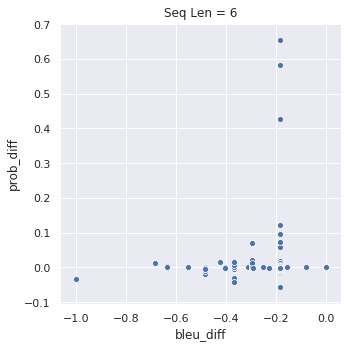

In [42]:
# positive examples

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

curr_data = positive_data[['prob_diff', 'bleu_diff']]
ax.set_title(f'Seq Len = {seq_len}')

sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=ax)
    
fig.tight_layout()

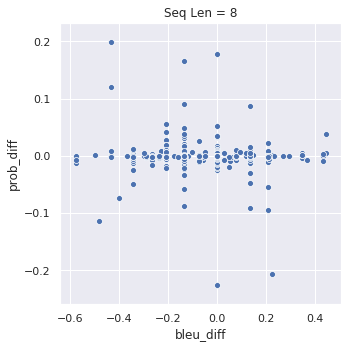

In [36]:
# positive examples

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

curr_data = positive_data[['prob_diff', 'bleu_diff']]
ax.set_title(f'Seq Len = {seq_len}')

sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=ax)
    
fig.tight_layout()